In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F
import pandas as pd
import numpy as np
import json

import sys
import os

sys.path.append(os.path.abspath('../'))
from tool import *

data_root = '../../MyData/'

# Load data (new embedding with GICS_Sector)

In [2]:
new_embedding_df = pd.read_csv("./data/embedding_256.csv")
print(len(new_embedding_df))
new_embedding_df.head()

1197


,cik,tic,Year,GICS_Sector,item1_embeddings,SP_LONG_DESC_embeddings,SP_SHORT_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,20.0,"[-0.5898345708847046, 0.980162501335144, -0.96...","[-0.8353348970413208, 0.973402738571167, -0.98...","[-0.6867204904556274, 0.9938115477561951, -0.9...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,352541,LNT,2021,55.0,"[0.9820889830589294, 0.4754180908203125, 0.869...","[0.9716767072677612, 0.7131884098052979, 0.879...","[0.9754056930541992, 0.2400549054145813, 0.895...","[0.972804069519043, 0.9935750365257263, 0.9685...","[0.8935458064079285, 0.9151054620742798, 0.755..."
2,1704715,AMR,2021,15.0,"[0.9945562481880188, -0.4087281823158264, 0.68...","[0.9718917012214661, -0.33507728576660156, 0.9...","[0.9910370111465454, -0.38968169689178467, 0.1...","[0.9949943423271179, -0.8197710514068604, 0.87...","[0.9967610239982605, -0.36475804448127747, 0.7..."
3,1575515,SFM,2021,30.0,"[-0.9608494639396667, -0.926054060459137, -0.9...","[-0.9911385178565979, -0.9708278775215149, -0....","[-0.9603582620620728, -0.9756494164466858, -0....","[-0.9450609087944031, -0.40782180428504944, -0...","[-0.13962775468826294, -0.8745130896568298, -0..."
4,1125376,ENSG,2021,35.0,"[-0.9341953992843628, -0.137389674782753, -0.9...","[-0.9762463569641113, -0.8669420480728149, -0....","[-0.8951124548912048, -0.10518676787614822, -0...","[0.1766112595796585, 0.7543022036552429, -0.99...","[-0.07263371348381042, 0.22911271452903748, -0..."


In [3]:
# total_embedding = obtain_total_embedding(data_root)
# print(len(total_embedding))

# # Check dataset
# nan_proportion = total_embedding.isna().mean()
# print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

# Train classifier

### Prepare training data and label

The input of the classifier is the single view embedding (256).

In [4]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'SP_SHORT_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year', 'GICS_Sector']

# Drop rows that don't have GICS label
exp_df = convert_to_array(new_embedding_df.dropna(subset=['GICS_Sector']), info_list, target_list, 256, False)

# Dictionary to store the stacked embeddings
embedding_arrays = {}
label_arrays = {}

# Loop through the columns and apply np.vstack
for col in target_list:
    embedding_arrays[col] = np.vstack(exp_df[col].values)
    nan_mask = ~np.any(np.isnan(embedding_arrays[col]), axis=1)

    embedding_arrays[col] = embedding_arrays[col][nan_mask]
    label_arrays[col] = exp_df['GICS_Sector'][nan_mask]

item1_embeddings
SP_LONG_DESC_embeddings
SP_SHORT_DESC_embeddings
ORBIS_PROD_SERV_embeddings
ORBIS_OVERVIEW_embeddings


In [5]:
X = np.vstack([embedding_arrays['item1_embeddings'],
               embedding_arrays['SP_LONG_DESC_embeddings'],
               embedding_arrays['SP_SHORT_DESC_embeddings'],
               embedding_arrays['ORBIS_PROD_SERV_embeddings'],
               embedding_arrays['ORBIS_OVERVIEW_embeddings']])
print(type(X))
print(X.shape)

label_df = pd.concat([label_arrays['item1_embeddings'],
                    label_arrays['SP_LONG_DESC_embeddings'],
                    label_arrays['SP_SHORT_DESC_embeddings'],
                    label_arrays['ORBIS_PROD_SERV_embeddings'],
                    label_arrays['ORBIS_OVERVIEW_embeddings']], ignore_index=True)
Y = pd.get_dummies(label_df)
print(type(Y))
print(Y.shape)

<class 'numpy.ndarray'>
(5362, 256)
<class 'pandas.core.frame.DataFrame'>
(5362, 11)


In [6]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # Input features
y_tensor = torch.tensor(Y.values, dtype=torch.float32)  # One-hot encoded labels (convert from DataFrame)

# Custom Dataset class with labels
class clasf_Dataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return both input data (features) and corresponding labels
        return self.features[idx], self.labels[idx]

# Create the full dataset with both features and labels
dataset = clasf_Dataset(X_tensor, y_tensor)

# Split dataset into train and test (80% train, 20% test)
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for train and test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the shape of a batch (should print both features and labels)
for batch in train_loader:
    features, labels = batch
    print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")  # (64, 1536) for features, (64, 11) for labels
    break  # Just print the first batch



Features shape: torch.Size([64, 256]), Labels shape: torch.Size([64, 11])


### Training Loop

In [10]:
from model.obtain_model import init_clasf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters
input_dim = 256
hidden_dim = 128
num_class = 11
drop_rate = 0.1

clasf = init_clasf(device, input_dim, hidden_dim, num_class, drop_rate)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(clasf.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    clasf.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Pre-process
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = clasf(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize the model
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (highest logit)
        total += labels.size(0)

        _, classes = torch.max(labels, 1)
        correct += (predicted == classes).sum().item()
    
    # Print training statistics for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


    # Evaluation loop (on the test dataset)
    clasf.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            # Pre-process
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Projection and predict
            outputs, _ = clasf(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            _, classes = torch.max(labels, 1)
            correct += (predicted == classes).sum().item()

    # Print test accuracy
    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Test [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}% \n")


Epoch [1/30], Loss: 1.0365, Accuracy: 70.59%
Test [1/30], Loss: 0.4431, Accuracy: 88.07% 

Epoch [2/30], Loss: 0.3852, Accuracy: 89.31%
Test [2/30], Loss: 0.3217, Accuracy: 89.94% 

Epoch [3/30], Loss: 0.2687, Accuracy: 92.50%
Test [3/30], Loss: 0.2995, Accuracy: 91.06% 

Epoch [4/30], Loss: 0.2036, Accuracy: 94.76%
Test [4/30], Loss: 0.2677, Accuracy: 92.92% 

Epoch [5/30], Loss: 0.1639, Accuracy: 95.96%
Test [5/30], Loss: 0.2542, Accuracy: 92.92% 

Epoch [6/30], Loss: 0.1361, Accuracy: 96.82%
Test [6/30], Loss: 0.2480, Accuracy: 93.04% 

Epoch [7/30], Loss: 0.1263, Accuracy: 96.55%
Test [7/30], Loss: 0.2445, Accuracy: 92.55% 

Epoch [8/30], Loss: 0.0979, Accuracy: 97.54%
Test [8/30], Loss: 0.2216, Accuracy: 94.29% 

Epoch [9/30], Loss: 0.0805, Accuracy: 98.18%
Test [9/30], Loss: 0.2447, Accuracy: 93.42% 

Epoch [10/30], Loss: 0.0728, Accuracy: 98.20%
Test [10/30], Loss: 0.2607, Accuracy: 93.17% 

Epoch [11/30], Loss: 0.0794, Accuracy: 97.85%
Test [11/30], Loss: 0.2503, Accuracy: 93.7

In [ ]:
# torch.save(clasf.state_dict(), "../model/saved_models/clasf.pth")

# Test Classifier

### Load classifier

In [7]:
from model.obtain_model import load_clasf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_clasf = load_clasf("../model/saved_models/clasf.pth", device)

### Prepare data

In [11]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'SP_SHORT_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year', 'GICS_Sector']

# Drop rows that don't have GICS label
exp_df = convert_to_array(new_embedding_df.dropna(subset=['GICS_Sector']), info_list, target_list, 256, False)
print(type(exp_df))
print(exp_df.shape)


# Dictionary to store the stacked embeddings as PyTorch tensors
embedding_tensors = {}
for col in target_list:
    numpy_array = np.vstack(exp_df[col].values)  # Stack the column values
    embedding_tensors[col] = torch.tensor(numpy_array, dtype=torch.float32)  # Convert to tensor

item1_embeddings
SP_LONG_DESC_embeddings
SP_SHORT_DESC_embeddings
ORBIS_PROD_SERV_embeddings
ORBIS_OVERVIEW_embeddings
<class 'pandas.core.frame.DataFrame'>
(1189, 9)


In [ ]:
# trained_clasf = clasf
latent_tensors = {}
for col in target_list:
    latent_tensors[col] = safe_inference(trained_clasf, embedding_tensors[col].to(device))

In [14]:
'''
Calculate the average of 
'''
def average_tensors(tensor_dict):
    """
    Computes the element-wise average of 2D tensors in a dictionary, 
    while handling NaN values properly.
    
    :param tensor_dict: Dictionary where values are 2D tensors of the same shape
    :return: A 2D tensor with the averaged values
    """
    tensor_list = list(tensor_dict.values())  # Extract tensors
    
    # Stack tensors along a new dimension (shape: [num_tensors, rows, cols])
    stacked_tensors = torch.stack(tensor_list, dim=0)

    # Create a mask for valid (non-NaN) values
    valid_mask = ~torch.isnan(stacked_tensors)

    # Replace NaNs with 0 for summation
    stacked_tensors = torch.nan_to_num(stacked_tensors, nan=0.0)

    # Sum across all tensors (axis=0)
    summed_tensors = torch.sum(stacked_tensors, dim=0)

    # Count valid (non-NaN) values at each position
    valid_counts = valid_mask.sum(dim=0)

    # Avoid division by zero and compute the average
    average_tensor = summed_tensors / torch.clamp(valid_counts, min=1)

    return average_tensor

average_latent = average_tensors(latent_tensors).cpu()

In [15]:
average_latent

tensor([[-0.5181,  0.1463,  0.1689,  ..., -0.2375, -0.1335, -0.1727],
        [-0.0371,  0.0511,  0.3274,  ..., -0.3358,  0.1396,  0.7705],
        [-0.0539,  0.0087,  0.8242,  ...,  1.2084, -0.2149, -0.0642],
        ...,
        [ 1.6632, -0.6519, -0.3185,  ..., -0.3819, -0.9256, -0.0746],
        [-0.2407, -0.5734, -1.0593,  ..., -0.6665,  0.3254, -0.0896],
        [-0.3100, -0.3664, -0.1698,  ...,  0.2064,  0.0096,  0.0109]])

In [16]:
exp_df = exp_df[['cik', 'tic', 'Year']]
exp_df['cluster_10'] = cluster(average_latent, 10)
exp_df['cluster_100'] = cluster(average_latent, 100)
exp_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.09444239482446515
Normalized Within-Cluster Sum of Squares (WCSS): 0.048223121713649536


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,7,86
1,352541,LNT,2021,8,14
2,1704715,AMR,2021,1,62
3,1575515,SFM,2021,5,96
4,1125376,ENSG,2021,0,12
...,...,...,...,...,...
1192,1021860,NOV,2021,9,46
1193,1744489,DIS,2021,2,11
1194,1102112,PACW,2021,4,91
1195,28823,DBD,2021,3,87


In [17]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp_returns = pd.merge(exp_df, returns_long, on='tic', how='inner')

exp_intra_corrs_10 = intra_industry_correlations(exp_returns, "cluster_10")
exp_avg_intra_corr_10 = np.nanmean(list(exp_intra_corrs_10.values()))
print(exp_avg_intra_corr_10)

exp_intra_corrs_100 = intra_industry_correlations(exp_returns, "cluster_100")
exp_avg_intra_corr_100 = np.nanmean(list(exp_intra_corrs_100.values()))
print(exp_avg_intra_corr_100)

print(len(exp_returns['cik'].unique()))

0.39745568349950566
0.4397911663302817
1061


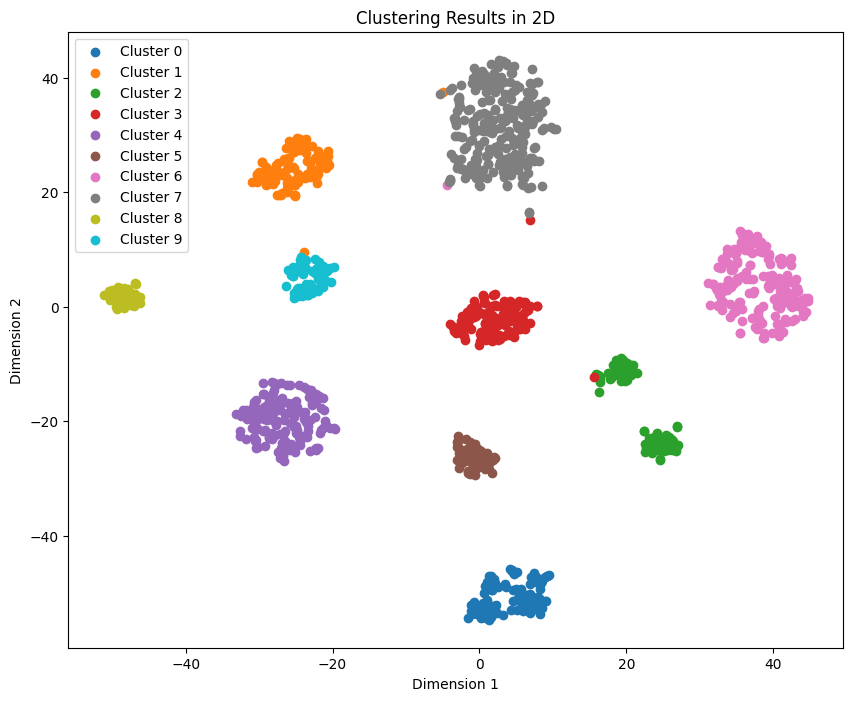

In [18]:
show_cluster_graph(average_latent, exp_df['cluster_10'])

In [ ]:
# exp_df.to_csv("../clustering_res/6_clasf.csv", index=False)